In [2]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

### CNN（Convolutional Neural Networks，卷积神经网络）


#### 主要特点:
    1、相邻层的神经元间的连接是非全连接的
    2、同一层中某些神经元之间的连接的权重是共享的

#### 约束：
    1、特征提取：每一个神经元从上一层的局部接受域得到突触输入，因而迫使它提取局部特征。一旦一个特征被提取出来， 只要它相对于其他特征的位置被近似地保留下来，它的精确位置就变得没有那么重要了。
    2、特征映射：网络的每一个隐含层都是由多个特征映射（feature map）组成的，每个特征映射都是二阶张量形式的。张量中的神经元共享同一种卷积核，这种结构形式具有如下的有益效果：a.平移不变性。b.自由参数数量的缩减(通过权值共享实现)。
    3、子采用（pooling）。每个卷积层后面跟着一个实现局部平均和子抽样的计算层，由此特征映射的分辨率降低。这种操作能够使特征映射的输出对平移和其他变形的敏感度下降。

#### ①卷积
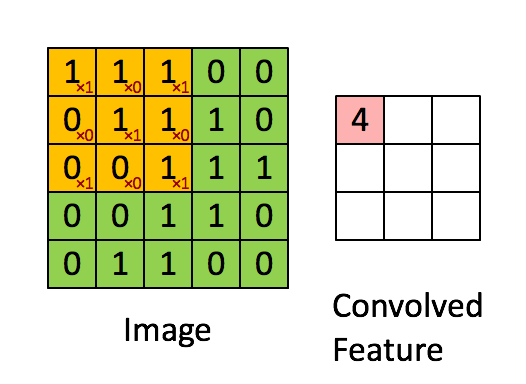

    每个卷积都是一种特征提取方式，通过一种特征提取可得到一个feature map。上图右边的3×3矩阵就是一个feature map，使用不同的卷积核可得到多种feature map。

#### ②滑动的步长(stride)
    步长(stride)决定了卷积核在移动过程中一次跳过几格。上面那张图片从左到右，每次滑动的时候只移动一格。  

#### ③卷积的边界处理(padding)
    tensorflow中卷积的 padding参数可以设为两个值SAME，VALID

    VALID模式如上图所示，对原始图像进行卷积，卷积后的矩阵只有3×3阶，比原来的图片要小了

    SAME模式要求卷积后的feature map与输入的矩阵大小相同，因此需要对输入矩阵的外层包裹n层0，然后再按照VALID的卷积方法进行卷积。n的求法如下式：

    SAME：edge_row = (kernel_row - 1) / 2; edge_cols = (kernel_cols - 1) / 2;
    VALID：edge_row = edge_cols = 0;
    其中，edge_row是包裹0的行数，edge_cols是包裹0的列数 , kernel_row就卷积核的行数

#### ④池化(Pooling)
 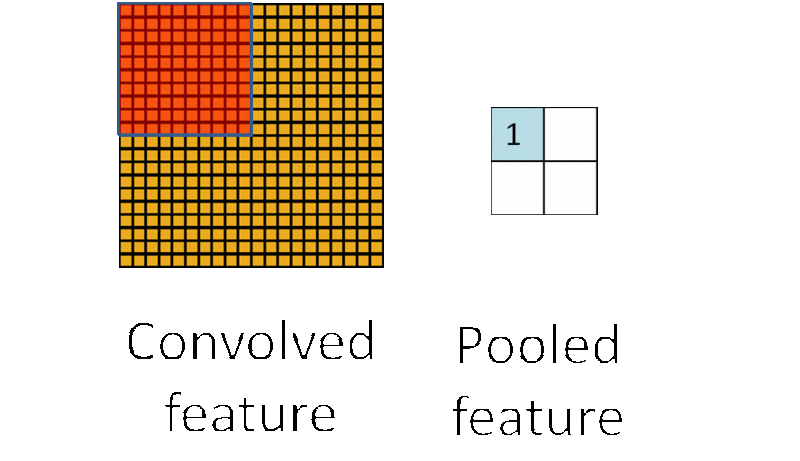
 
     通过将卷积层提取到的特征输入至分类器中进行训练，可以实现输出最终的分类结果。理论上可以直接将卷积层提取到的所有特征输入至分类器中，然而这将需要非常大的计算开销。例如：对于一个输入为96×96大小的图像样本，假设在卷积层使用200个8×8大小的卷积核对该输入图像进行卷积运算操作，每个卷积核都输出一个（96-8＋1）×（96-8＋1）=7921维的特征向量，最终卷积层将输出一个7921×200=1584200维的特征向量。将如此高维度的特征输入至分类器中进行训练需要耗费非常庞大的计算资源，同时也会产生严重的过拟合问题。

     由于图像具有 “静态性”，在图像的一个局部区域得到的特征极有可能在另一个局部区域同样适用。因此，可以对图像的一个局部区域中不同位置的特征进行聚合统计，这种操作称为“池化”(也称作子采样)。池化分为两种，一种是最大池化，在选中区域中找最大的值作为Pooling后的值，另一种是平均值池化，把选中的区域中的平均值作为Pooling后的值。

In [3]:
# 导入数据
mnist = input_data.read_data_sets('MNIST_data',one_hot=True)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [35]:
# 定义网络中的输入数据
xs = tf.placeholder(tf.float32, [None, 784])/255.   # 28x28
ys = tf.placeholder(tf.float32, [None, 10])
keep_prob = tf.placeholder(tf.float32)
x_image = tf.reshape(xs, [-1, 28, 28, 1])
# x_image.shape = [n_samples,28,28,1]
# 其中1是黑白两色的意思，也就是图片的层，或者厚度？

In [30]:
# 辅助函数，用来计算预测的准确性
def compute_accuracy(v_xs, v_ys):
    global prediction
    y_pre = sess.run(prediction, feed_dict={xs: v_xs, keep_prob: 1})
    correct_prediction = tf.equal(tf.argmax(y_pre,1), tf.argmax(v_ys,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    result = sess.run(accuracy, feed_dict={xs: v_xs, ys: v_ys, keep_prob: 1})
    return result

In [32]:
# 接下来的四个函数~~
def weight_variable(shape):
    # 返回初始化的weights
    initial = tf.truncated_normal(shape, stddev=0.1)# 产生随机数
    return tf.Variable(initial)

def bias_variable(shape):
    # 返回初始化的bias
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    # 卷积层的计算结果
    # stride [1, x_movement, y_movement, 1]
    # Must have strides[0] = strides[3] = 1
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    # 有max和mean 两种
    # stride[0],stride[3]也必须是1
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

In [36]:
# 创建网络结构

## 卷基层1
W_conv1 = weight_variable([5,5, 1,32]) # patch 5x5(可以理解为探头其实~), in size 1(黑白), out size 32(新的高度)
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1) # output size 28x28x32
h_pool1 = max_pool_2x2(h_conv1)                         # output size 14x14x32

## 卷基层2
W_conv2 = weight_variable([5,5, 32, 64]) # patch 5x5, in size 32, out size 64
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2) # output size 14x14x64
h_pool2 = max_pool_2x2(h_conv2)                         # output size 7x7x64

## 普通的神经层1
W_fc1 = weight_variable([7*7*64, 1024])
b_fc1 = bias_variable([1024])
# [n_samples, 7, 7, 64] ->> [n_samples, 7*7*64]
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

## 普通的神经层2
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
prediction = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)


In [40]:
# 定义优化目标，训练步骤，创建会话对象
cross_entropy = tf.reduce_mean(-tf.reduce_sum(ys * tf.log(prediction),
                                              reduction_indices=[1]))       # loss
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
sess = tf.Session()

In [41]:
# 初始化参数，并执行
init = tf.global_variables_initializer()
sess.run(init)

In [42]:
for i in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={xs: batch_xs, ys: batch_ys, keep_prob: 0.5})
    if i % 50 == 0:
        print(compute_accuracy(
            mnist.test.images, mnist.test.labels))

0.1314
0.7712
0.8754
0.9067
0.9316
0.9387
0.9484
0.9508
0.9535
0.9528
0.9616
0.9631
0.9648
0.9651
0.9673
0.967
0.9709
0.9701
0.9728
0.97
